In [37]:
import os
import git
from pathlib import Path

from typing import List
import plotly.express as px
import ipywidgets as widgets
from IPython.display import display
import plotly.graph_objects as go
from IPython.display import clear_output
import pylustrator

ROOT_DIR =  Path(git.Repo('.', search_parent_directories=True).working_tree_dir)
SAVE_FIGS = True
os.chdir(os.path.join(ROOT_DIR, "utilities"))
from testing import * # If MATLAB is not installed, open utilities and set to False
from plotting import *
os.chdir(os.path.join(ROOT_DIR, "results", "combined_results"))
np.random.seed(0)
plots_path = os.path.join(ROOT_DIR, "poster", "plots")

In [38]:
def variance_prior(r, eta, scale=1):
    beta = (eta+1.5)/r
    var_prior = scale * scipy.special.gamma(beta + 1/r)/scipy.special.gamma(beta)
    return var_prior

def kurtosis_prior(r, eta, fisher=True):
    beta = (eta+1.5)/r
    kurtosis = 3*scipy.special.gamma(beta + 2/r)*scipy.special.gamma(beta)/scipy.special.gamma(beta+1/r)**2 
    if fisher:
        return kurtosis - 3
    else:
        return kurtosis 

fixed_palette = {
    'gray': 'xkcd:gray',
    'green': 'xkcd:shamrock green',
    'red': 'xkcd:light red',
    'blue': 'xkcd:blue',
}


def find_master_dfs(root_dir: str) -> List[str]:
    root_path = Path(root_dir)
    if not root_path.exists():
        raise FileNotFoundError(f"Directory not found: {root_dir}")

    master_df_paths = []
    for current_dir, _, files in os.walk(root_path):
        if 'master_df.csv' in files:
            master_df_path = Path(os.path.join(current_dir, 'master_df.csv'))
            master_df_paths.append(str(master_df_path.absolute()))
    return master_df_paths

relevant_cols = ['group', 'obs_var', 'var_lower', 'var_upper', 'obs_kurt', 'kurt_lower',
       'kurt_upper', 'total_samples', 'initial_r', 'initial_eta',
       'kstest_stat_initial', 'kstest_stat_cutoff_0.05', 'kstest_stat_eta0',
       'best_r_eta0', 'best_r', 'best_eta', 'kstest_stat_best', 'iter1_r',
       'iter1_eta', 'kstest_stat_iter1', 'n_pval_0.05', 'param_gaussian',
       'kstest_stat_gaussian', 'kstest_pval_gaussian', 'param_laplace',
       'kstest_stat_laplace', 'kstest_pval_laplace', 'param_t',
       'kstest_stat_t', 'kstest_pval_t', 'kstest_pval_gengamma', 'dataset', 'transform', 'size', 'channel']

all_paths = find_master_dfs('..\case-studies')
all_master_dfs = []

for path in all_paths:
    dataset, transform, size, channel, _, _ = Path(path).parts[-6:]
    master_df = pd.read_csv(path)
    master_df = master_df.rename(columns={master_df.columns[0]: 'group'})#.set_index('group')
    master_df['dataset'] = dataset
    master_df['transform'] = transform
    master_df['size'] = size
    master_df['channel'] = channel

    all_master_dfs.append(master_df[relevant_cols])
    
main_df = pd.concat(all_master_dfs)
main_df['prior_var'] = main_df.apply(lambda row : variance_prior(row.loc['best_r'], row.loc['best_eta']), axis = 1)
main_df['prior_kurt'] = main_df.apply(lambda row : kurtosis_prior(row.loc['best_r'], row.loc['best_eta']), axis = 1)
main_df['gaussian_kurt'] = np.zeros(main_df.shape[0])
main_df['laplace_kurt'] = 3*np.ones(main_df.shape[0])
main_df['best_beta'] = (main_df['best_eta'] + 1.5)/main_df['best_r'] 

frequency_map = pd.read_csv(os.path.join(ROOT_DIR, "transformed-data", "master-frequency-map.csv")).set_index(['dataset', 'transform', 'group'])
main_df = main_df.set_index(['dataset', 'transform', 'group']).merge(frequency_map, left_index = True, right_index=True).reset_index()
main_df

,dataset,transform,group,obs_var,var_lower,var_upper,obs_kurt,kurt_lower,kurt_upper,total_samples,...,kstest_pval_t,kstest_pval_gengamma,size,channel,prior_var,prior_kurt,gaussian_kurt,laplace_kurt,best_beta,frequency
0,agriVision,fourier,2,3.389382e+08,1.963741e+08,5.527124e+08,421.841550,123.974430,696.238040,45000.0,...,1.382990e-14,1.040585e-02,batch0approx1e5,blue,8.662839e+07,17.410192,0.0,3.0,15.379747,0.008394
1,agriVision,fourier,5,1.737109e+08,1.001625e+08,3.273177e+08,628.030000,108.212240,1663.239500,117000.0,...,3.910420e-23,4.417691e-09,batch0approx1e5,blue,3.590489e+07,12.747080,0.0,3.0,16.190476,0.013218
2,agriVision,fourier,8,6.727504e+07,3.507278e+07,1.706153e+08,1363.730700,99.365600,3639.235800,189000.0,...,2.031100e-27,1.284655e-05,batch0approx1e5,blue,1.592314e+07,13.211559,0.0,3.0,15.000000,0.020181
3,agriVision,fourier,11,3.197149e+07,1.499865e+07,1.022867e+08,2698.317600,93.680930,4889.278000,495000.0,...,1.306900e-42,5.197276e-08,batch0approx1e5,blue,7.901878e+06,12.119417,0.0,3.0,14.662921,0.030472
4,agriVision,fourier,14,1.270560e+07,6.076386e+06,3.976188e+07,2654.295200,86.305040,4711.629400,1134000.0,...,1.516550e-83,7.405179e-12,batch0approx1e5,blue,3.491911e+06,9.826406,0.0,3.0,14.893617,0.046298
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
282,spaceNet,wavelet,5,3.739722e+02,3.631603e+02,3.849922e+02,10.399796,7.744357,15.153512,1149538.0,...,0.000000e+00,0.000000e+00,approx1e5,red,1.988715e+03,225.923873,0.0,3.0,2.368421,0.199222
283,spaceNet,wavelet,6,9.055869e+01,8.797025e+01,9.337066e+01,11.086198,8.393261,15.483007,4251250.0,...,0.000000e+00,0.000000e+00,approx1e5,red,2.538421e+02,66.899597,0.0,3.0,2.375000,0.249027
284,spaceNet,wavelet,7,2.086429e+01,2.013236e+01,2.165660e+01,18.333370,11.867616,29.351609,17005000.0,...,0.000000e+00,0.000000e+00,approx1e5,red,4.285132e+01,54.023663,0.0,3.0,1.750000,0.332036
285,spaceNet,wavelet,8,4.537877e+00,4.343649e+00,4.747077e+00,28.597766,17.033248,47.502076,68020000.0,...,0.000000e+00,0.000000e+00,approx1e5,red,3.270914e+00,19.010542,0.0,3.0,1.141553,0.498054


## How do we compare to other priors?

In [39]:
fontsize = 20
markersize = 10
labelsize = 20
markertypes = ['x', 'D', 'o', '+']
labels = ['GenGamma', 'Laplace', 'Gaussian', 'Student-t', r'$\alpha=0.05$']
points = [Line2D([0], [0], color='k', linestyle='', marker=m, markersize=10) for m in markertypes] + [Line2D([0], [0], color='k', linestyle='-', linewidth=2)]

## END RESULT

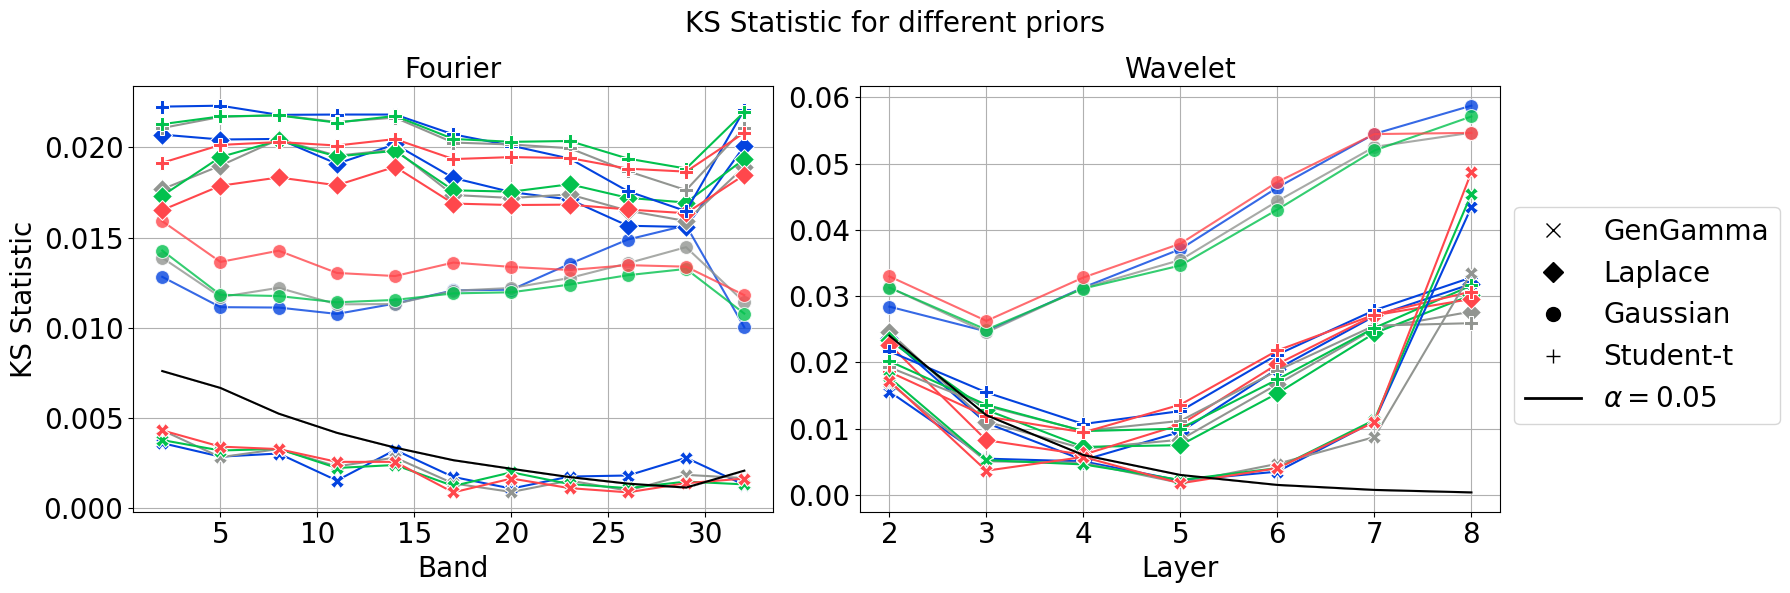

In [40]:
hue = 'channel'
dataset_name = 'pastis'
fixed_palette = {'gray': 'xkcd:gray','green': 'xkcd:shamrock green', 'red': 'xkcd:light red','blue': 'xkcd:blue'}

transform = 'fourier'
dataset_filter = (main_df['dataset'] == dataset_name)
transform_filter = (main_df['transform'] == transform)
temp = main_df[dataset_filter & transform_filter]

fig, axes = plt.subplots(1, 2, figsize=(18, 6))
fig.suptitle(f"KS Statistic for different priors", fontsize=fontsize)

sns.lineplot(data=temp, x='group', y='kstest_stat_gaussian', hue=hue, palette=fixed_palette, marker='o', alpha=0.8, ax=axes[0], markersize = markersize)
sns.lineplot(data=temp, x='group', y='kstest_stat_laplace', hue=hue, palette=fixed_palette, marker='D', ax=axes[0], markersize = markersize)
sns.lineplot(data=temp, x='group', y='kstest_stat_t', hue=hue, palette=fixed_palette, marker='P', ax=axes[0], markersize = markersize)
sns.lineplot(data=temp, x='group', y='kstest_stat_best', hue=hue, palette=fixed_palette, marker='X', ax=axes[0], markersize = markersize)
sns.lineplot(data=temp, x='group', y='kstest_stat_cutoff_0.05', color='black', ax=axes[0])
axes[0].set_xlabel("Band", fontsize=fontsize)
axes[0].set_ylabel("KS Statistic", fontsize=fontsize)
axes[0].legend(points, labels, fontsize = 12).set_visible(False)
axes[0].grid(True)
axes[0].set_title("Fourier", fontsize=fontsize)
axes[0].tick_params(axis='both', which='major', labelsize=fontsize)

transform = 'wavelet'
transform_filter = (main_df['transform'] == transform)
temp = main_df[dataset_filter & transform_filter]

sns.lineplot(data=temp, x='group', y='kstest_stat_gaussian', hue=hue, palette=fixed_palette, marker='o', alpha=0.8, ax=axes[1], markersize = markersize)
sns.lineplot(data=temp, x='group', y='kstest_stat_laplace', hue=hue, palette=fixed_palette, marker='D', ax=axes[1], markersize = markersize)
sns.lineplot(data=temp, x='group', y='kstest_stat_t', hue=hue, palette=fixed_palette, marker='P', ax=axes[1], markersize = markersize)
sns.lineplot(data=temp, x='group', y='kstest_stat_best', hue=hue, palette=fixed_palette, marker='X', ax=axes[1], markersize = markersize)
sns.lineplot(data=temp, x='group', y='kstest_stat_cutoff_0.05', color='black', ax=axes[1])
axes[1].set_xlabel("Layer", fontsize=fontsize)
axes[1].set_ylabel("", fontsize=fontsize)
axes[1].legend(points, labels, fontsize = 20, bbox_to_anchor = (1, 0.75))#.set_visible(False)
axes[1].grid(True)
axes[1].set_title("Wavelet", fontsize=fontsize)
axes[1].tick_params(axis='both', which='major', labelsize=fontsize)
plt.tight_layout()
plt.show()

if SAVE_FIGS:
    fig.figure.savefig(os.path.join(plots_path, f"ksstat_across_priors_{dataset_name}_3.jpg"), dpi=1000, bbox_inches='tight')

# Extract tick parameters for both axes
x_tick_values_0 = axes[0].get_xticks()
y_tick_values_0 = axes[0].get_yticks()
x_tick_values_1 = axes[1].get_xticks()
y_tick_values_1 = axes[1].get_yticks()

# Extract xlim and ylim for both axes
x_lim_0 = axes[0].get_xlim()
y_lim_0 = axes[0].get_ylim()
x_lim_1 = axes[1].get_xlim()
y_lim_1 = axes[1].get_ylim()

## Step 1: Single-Channel (Gray) Prior 

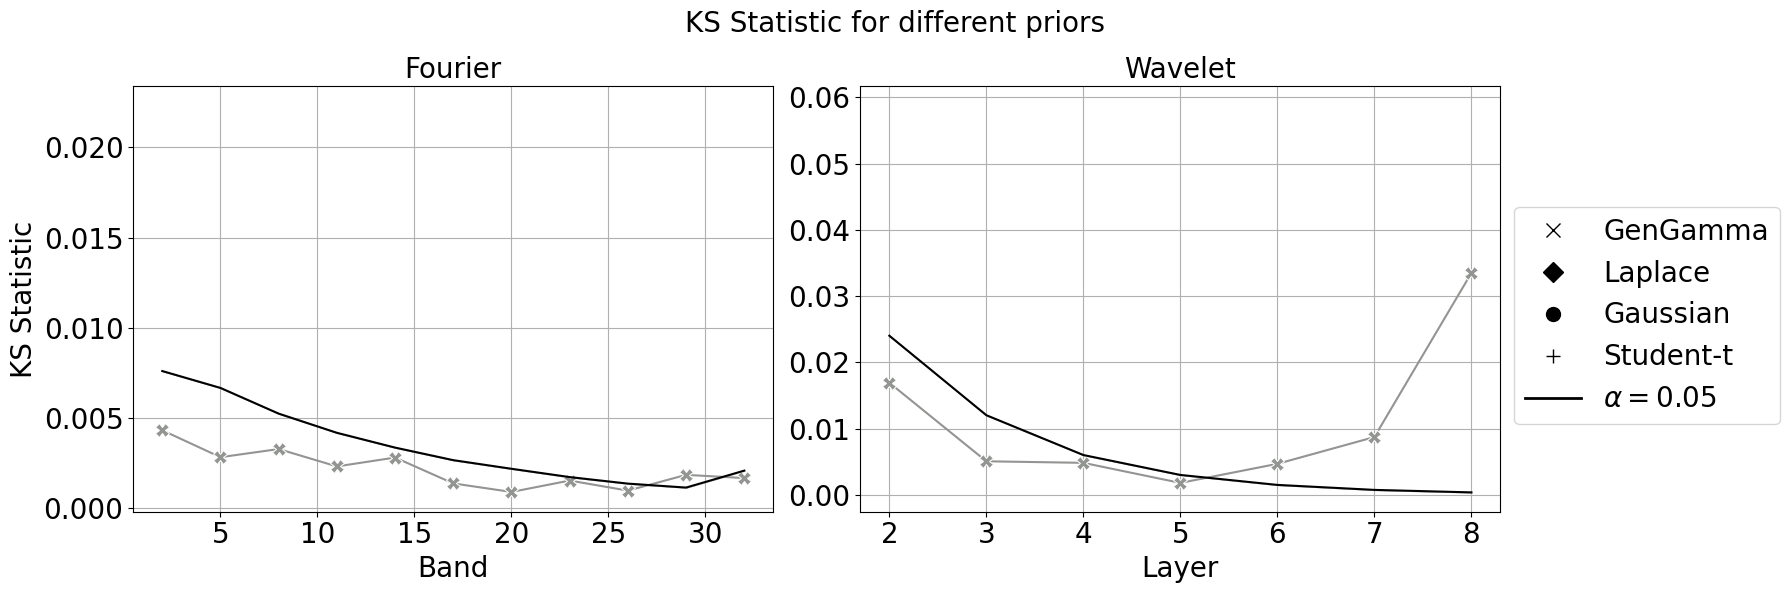

In [41]:
hue = 'channel'
dataset_name = 'pastis'
fixed_palette = {'gray': 'xkcd:gray','green': 'xkcd:shamrock green', 'red': 'xkcd:light red','blue': 'xkcd:blue'}

transform = 'fourier'
dataset_filter = (main_df['dataset'] == dataset_name)
transform_filter = (main_df['transform'] == transform)
temp = main_df[dataset_filter & transform_filter]

fig, axes = plt.subplots(1, 2, figsize=(18, 6))
fig.suptitle(f"KS Statistic for different priors", fontsize=fontsize)

# sns.lineplot(data=temp, x='group', y='kstest_stat_gaussian', hue=hue, palette=fixed_palette, marker='o', alpha=0.8, ax=axes[0], markersize = markersize)
# sns.lineplot(data=temp, x='group', y='kstest_stat_laplace', hue=hue, palette=fixed_palette, marker='D', ax=axes[0], markersize = markersize)
# sns.lineplot(data=temp, x='group', y='kstest_stat_t', hue=hue, palette=fixed_palette, marker='P', ax=axes[0], markersize = markersize)
sns.lineplot(data=temp[temp['channel'] == 'gray'], x='group', y='kstest_stat_best', hue=hue, palette=fixed_palette, marker='X', ax=axes[0], markersize=markersize)
sns.lineplot(data=temp, x='group', y='kstest_stat_cutoff_0.05', color='black', ax=axes[0])
axes[0].set_xlabel("Band", fontsize=fontsize)
axes[0].set_ylabel("KS Statistic", fontsize=fontsize)
axes[0].legend(points, labels, fontsize=12).set_visible(False)
axes[0].grid(True)
axes[0].set_title("Fourier", fontsize=fontsize)
axes[0].tick_params(axis='both', which='major', labelsize=fontsize)
axes[0].set_xticks(x_tick_values_0)
axes[0].set_yticks(y_tick_values_0)
axes[0].set_xlim(x_lim_0)
axes[0].set_ylim(y_lim_0)

transform = 'wavelet'
transform_filter = (main_df['transform'] == transform)
temp = main_df[dataset_filter & transform_filter]

# sns.lineplot(data=temp, x='group', y='kstest_stat_gaussian', hue=hue, palette=fixed_palette, marker='o', alpha=0.8, ax=axes[1], markersize = markersize)
# sns.lineplot(data=temp, x='group', y='kstest_stat_laplace', hue=hue, palette=fixed_palette, marker='D', ax=axes[1], markersize = markersize)
# sns.lineplot(data=temp, x='group', y='kstest_stat_t', hue=hue, palette=fixed_palette, marker='P', ax=axes[1], markersize = markersize)
sns.lineplot(data=temp[temp['channel'] == 'gray'], x='group', y='kstest_stat_best', hue=hue, palette=fixed_palette, marker='X', ax=axes[1], markersize=markersize)
sns.lineplot(data=temp, x='group', y='kstest_stat_cutoff_0.05', color='black', ax=axes[1])
axes[1].set_xlabel("Layer", fontsize=fontsize)
axes[1].set_ylabel("", fontsize=fontsize)

axes[1].legend(points, labels, fontsize=20, bbox_to_anchor=(1, 0.75))
axes[1].grid(True)
axes[1].set_title("Wavelet", fontsize=fontsize)
axes[1].tick_params(axis='both', which='major', labelsize=fontsize)
axes[1].set_xticks(x_tick_values_1)
axes[1].set_yticks(y_tick_values_1)
axes[1].set_xlim(x_lim_1)
axes[1].set_ylim(y_lim_1)

plt.tight_layout()
plt.show()

if SAVE_FIGS:
    fig.figure.savefig(os.path.join(plots_path, f"ksstat_across_priors_{dataset_name}_1.jpg"), dpi=1000, bbox_inches='tight')

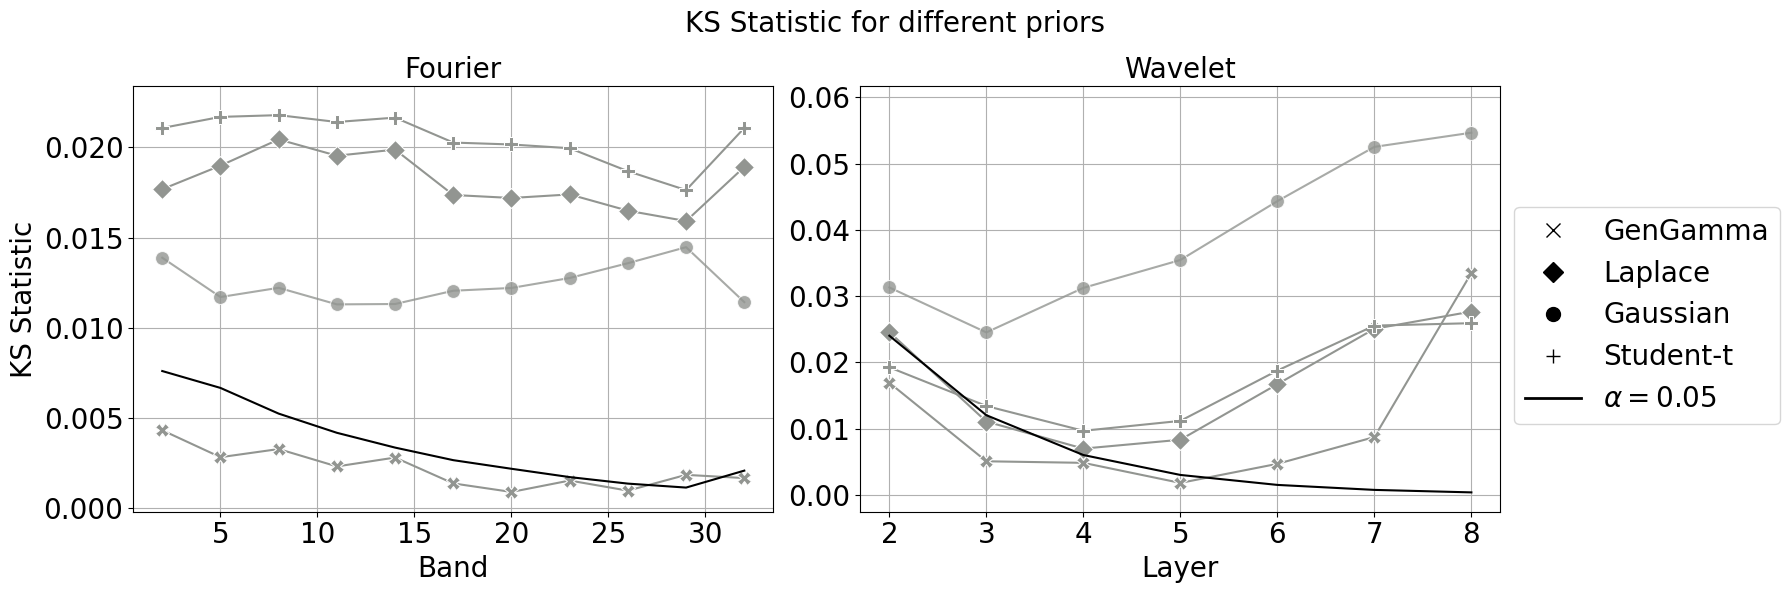

In [42]:
hue = 'channel'
dataset_name = 'pastis'
fixed_palette = {'gray': 'xkcd:gray','green': 'xkcd:shamrock green', 'red': 'xkcd:light red','blue': 'xkcd:blue'}

transform = 'fourier'
dataset_filter = (main_df['dataset'] == dataset_name)
transform_filter = (main_df['transform'] == transform)
channel_filter = (main_df['channel'] == 'gray')
temp = main_df[dataset_filter & transform_filter & channel_filter]

fig, axes = plt.subplots(1, 2, figsize=(18, 6))
fig.suptitle(f"KS Statistic for different priors", fontsize=fontsize)

sns.lineplot(data=temp, x='group', y='kstest_stat_gaussian', hue=hue, palette=fixed_palette, marker='o', alpha=0.8, ax=axes[0], markersize=markersize)
sns.lineplot(data=temp, x='group', y='kstest_stat_laplace', hue=hue, palette=fixed_palette, marker='D', ax=axes[0], markersize=markersize)
sns.lineplot(data=temp, x='group', y='kstest_stat_t', hue=hue, palette=fixed_palette, marker='P', ax=axes[0], markersize=markersize)
sns.lineplot(data=temp, x='group', y='kstest_stat_best', hue=hue, palette=fixed_palette, marker='X', ax=axes[0], markersize=markersize)
sns.lineplot(data=temp, x='group', y='kstest_stat_cutoff_0.05', color='black', ax=axes[0])
axes[0].set_xlabel("Band", fontsize=fontsize)
axes[0].set_ylabel("KS Statistic", fontsize=fontsize)
axes[0].legend(points, labels, fontsize=12).set_visible(False)
axes[0].grid(True)
axes[0].set_title("Fourier", fontsize=fontsize)
axes[0].tick_params(axis='both', which='major', labelsize=fontsize)
axes[0].set_xticks(x_tick_values_0)
axes[0].set_yticks(y_tick_values_0)
axes[0].set_xlim(x_lim_0)
axes[0].set_ylim(y_lim_0)

transform = 'wavelet'
transform_filter = (main_df['transform'] == transform)
temp = main_df[dataset_filter & transform_filter & channel_filter]

sns.lineplot(data=temp, x='group', y='kstest_stat_gaussian', hue=hue, palette=fixed_palette, marker='o', alpha=0.8, ax=axes[1], markersize=markersize)
sns.lineplot(data=temp, x='group', y='kstest_stat_laplace', hue=hue, palette=fixed_palette, marker='D', ax=axes[1], markersize=markersize)
sns.lineplot(data=temp, x='group', y='kstest_stat_t', hue=hue, palette=fixed_palette, marker='P', ax=axes[1], markersize=markersize)
sns.lineplot(data=temp, x='group', y='kstest_stat_best', hue=hue, palette=fixed_palette, marker='X', ax=axes[1], markersize=markersize)
sns.lineplot(data=temp, x='group', y='kstest_stat_cutoff_0.05', color='black', ax=axes[1])
axes[1].set_xlabel("Layer", fontsize=fontsize)
axes[1].set_ylabel("", fontsize=fontsize)
axes[1].legend(points, labels, fontsize=20, bbox_to_anchor=(1, 0.75))
axes[1].grid(True)
axes[1].set_title("Wavelet", fontsize=fontsize)
axes[1].tick_params(axis='both', which='major', labelsize=fontsize)
axes[1].set_xticks(x_tick_values_1)
axes[1].set_yticks(y_tick_values_1)
axes[1].set_xlim(x_lim_1)
axes[1].set_ylim(y_lim_1)

plt.tight_layout()
plt.show()

if SAVE_FIGS:
    fig.figure.savefig(os.path.join(plots_path, f"ksstat_across_priors_{dataset_name}_2.jpg"), dpi=1000, bbox_inches='tight')

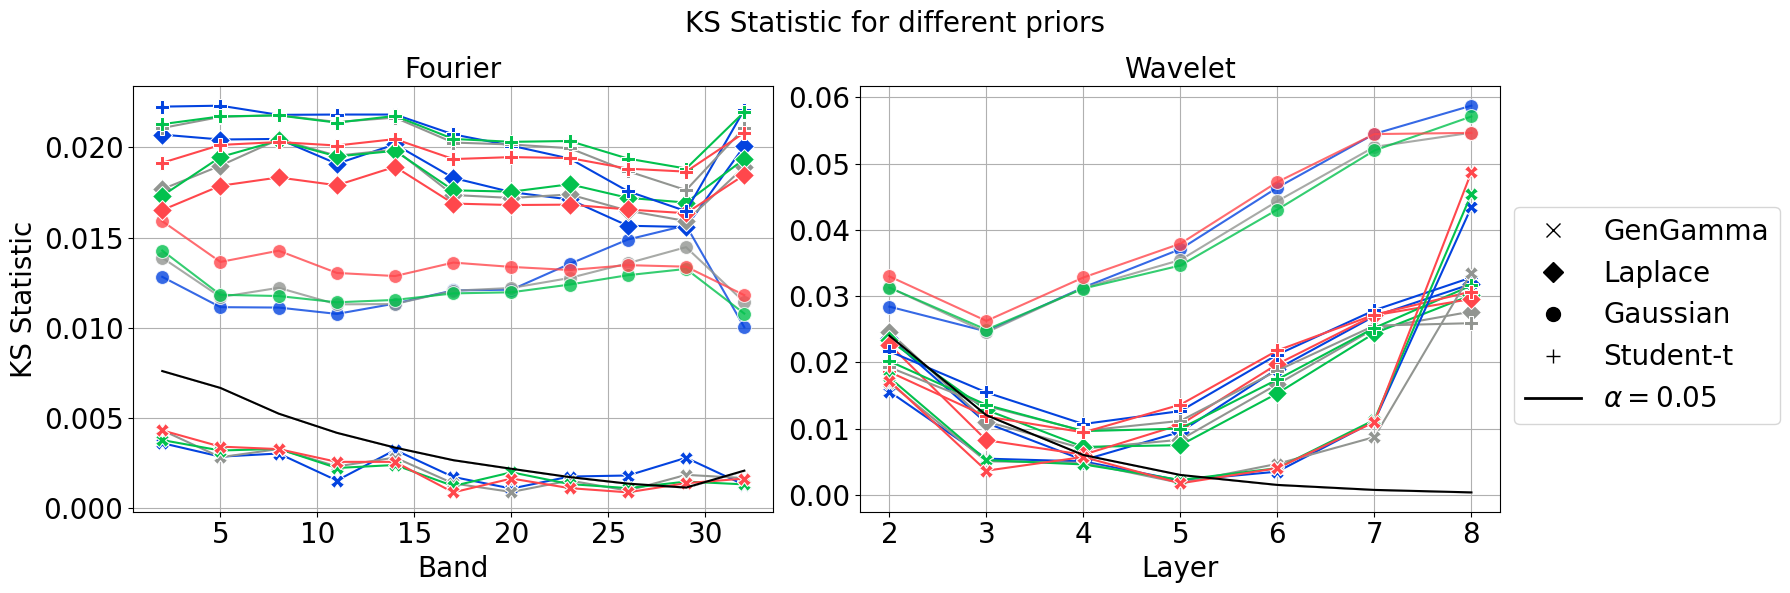

In [43]:
hue = 'channel'
dataset_name = 'pastis'
fixed_palette = {'gray': 'xkcd:gray','green': 'xkcd:shamrock green', 'red': 'xkcd:light red','blue': 'xkcd:blue'}

transform = 'fourier'
dataset_filter = (main_df['dataset'] == dataset_name)
transform_filter = (main_df['transform'] == transform)
temp = main_df[dataset_filter & transform_filter]

fig, axes = plt.subplots(1, 2, figsize=(18, 6))
fig.suptitle(f"KS Statistic for different priors", fontsize=fontsize)

sns.lineplot(data=temp, x='group', y='kstest_stat_gaussian', hue=hue, palette=fixed_palette, marker='o', alpha=0.8, ax=axes[0], markersize = markersize)
sns.lineplot(data=temp, x='group', y='kstest_stat_laplace', hue=hue, palette=fixed_palette, marker='D', ax=axes[0], markersize = markersize)
sns.lineplot(data=temp, x='group', y='kstest_stat_t', hue=hue, palette=fixed_palette, marker='P', ax=axes[0], markersize = markersize)
sns.lineplot(data=temp, x='group', y='kstest_stat_best', hue=hue, palette=fixed_palette, marker='X', ax=axes[0], markersize = markersize)
sns.lineplot(data=temp, x='group', y='kstest_stat_cutoff_0.05', color='black', ax=axes[0])
axes[0].set_xlabel("Band", fontsize=fontsize)
axes[0].set_ylabel("KS Statistic", fontsize=fontsize)
axes[0].legend(points, labels, fontsize = 12).set_visible(False)
axes[0].grid(True)
axes[0].set_title("Fourier", fontsize=fontsize)
axes[0].tick_params(axis='both', which='major', labelsize=fontsize)

transform = 'wavelet'
transform_filter = (main_df['transform'] == transform)
temp = main_df[dataset_filter & transform_filter]

sns.lineplot(data=temp, x='group', y='kstest_stat_gaussian', hue=hue, palette=fixed_palette, marker='o', alpha=0.8, ax=axes[1], markersize = markersize)
sns.lineplot(data=temp, x='group', y='kstest_stat_laplace', hue=hue, palette=fixed_palette, marker='D', ax=axes[1], markersize = markersize)
sns.lineplot(data=temp, x='group', y='kstest_stat_t', hue=hue, palette=fixed_palette, marker='P', ax=axes[1], markersize = markersize)
sns.lineplot(data=temp, x='group', y='kstest_stat_best', hue=hue, palette=fixed_palette, marker='X', ax=axes[1], markersize = markersize)
sns.lineplot(data=temp, x='group', y='kstest_stat_cutoff_0.05', color='black', ax=axes[1])
axes[1].set_xlabel("Layer", fontsize=fontsize)
axes[1].set_ylabel("", fontsize=fontsize)
axes[1].legend(points, labels, fontsize = 20, bbox_to_anchor = (1, 0.75))#.set_visible(False)
axes[1].grid(True)
axes[1].set_title("Wavelet", fontsize=fontsize)
axes[1].tick_params(axis='both', which='major', labelsize=fontsize)
plt.tight_layout()
plt.show()

if SAVE_FIGS:
    fig.figure.savefig(os.path.join(plots_path, f"ksstat_across_priors_{dataset_name}.jpg"), dpi=1000, bbox_inches='tight')